## Aprendizado Multiobjetivo em Modelos Supervisionados

**Dupla**: Beatriz Evelyn Dalfior (22.1.8012), Amanda Jacomette Dias Barbosa (22.1.8025)

**Disciplina**: Aprendizagem de Máquina (CSI704)

**Professor**: Luiz Carlos Bambirra Torres


---

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


---

### 1. Base de Dados:
O dataset utilizado nesse código é o [Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance), o qual contém 649 instâncias e 30 features. Utilizamos métodos de **regressão** para predição e análise, com a variável G3 (nota final) como **target**.

In [17]:
# ------------------ STUDENT PERFORMANCE ------------------
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 

# data (as pandas dataframes) 
X = student_performance.data.features 
y = student_performance.data.targets 
  
# metadata 
print(student_performance.metadata) 
  
# variable information 
print(student_performance.variables) 

np.random.seed(42)
tf.random.set_seed(42)


{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [18]:
# ------------------------- Preprocess dataset -------------------------
# Juntar X e y primeiro para garantir consistência
df = pd.concat([X, y], axis=1)

# Verificar quais colunas realmente existem no DataFrame
print("Colunas disponíveis no DataFrame:")
print(df.columns.tolist())

# Colunas categóricas esperadas
expected_cat_cols = [
    'school', 'sex', 'address', 'famsize', 'Pstatus',
    'Mjob', 'Fjob', 'reason', 'guardian',
    'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'higher', 'internet', 'romantic'
]

# Filtrar apenas as colunas que existem no DataFrame
cat_cols = [col for col in expected_cat_cols if col in df.columns]

print("\nColunas categóricas que serão codificadas:")
print(cat_cols)

print("\nValores faltantes antes do tratamento:")
print(df.isnull().sum())

# Preencher valores faltantes
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# One-hot encoding apenas nas colunas categóricas existentes
df = pd.get_dummies(df, columns=cat_cols)

X = df.drop(columns=y.columns)
y = df[y.columns]

print("\nNúmero de amostras em X e y:")
print(len(X), len(y))

df.head()

Colunas disponíveis no DataFrame:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

Colunas categóricas que serão codificadas:
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Valores faltantes antes do tratamento:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel 

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_14300\908820709.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\Beatriz\AppData\Local\Temp\ipykernel_14300\908820709.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,False,True,False,True,True,False,True,False
1,17,1,1,1,2,0,5,3,3,1,...,True,False,True,False,False,True,False,True,True,False
2,15,1,1,1,2,0,4,3,2,2,...,True,False,False,True,False,True,False,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,False,True,False,True,False,True,False,True,False,True
4,16,3,3,1,2,0,4,3,2,1,...,True,False,False,True,False,True,True,False,True,False


In [19]:
# ------------------- Train/Test split -------------------
# Selecionando features relevantes e target
feat = ['G1', 'G2', 'Medu', 'Fedu', 'Walc', 'absences', 'studytime', 'failures']
features = df[feat]
target = df['G3'] # Nota final do aluno

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("\nShapes após train/test split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


print("\nValores NaN em X_train:", X_train.isna().sum().sum())
print("Valores NaN em y_train:", y_train.isna().sum().sum())


Shapes após train/test split:
X_train: (454, 8), y_train: (454,)
X_test: (195, 8), y_test: (195,)

Valores NaN em X_train: 0
Valores NaN em y_train: 0


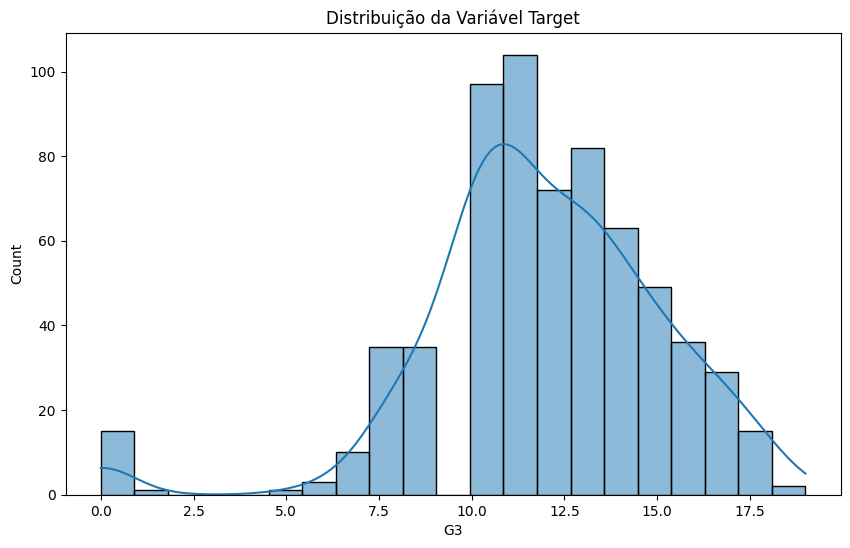

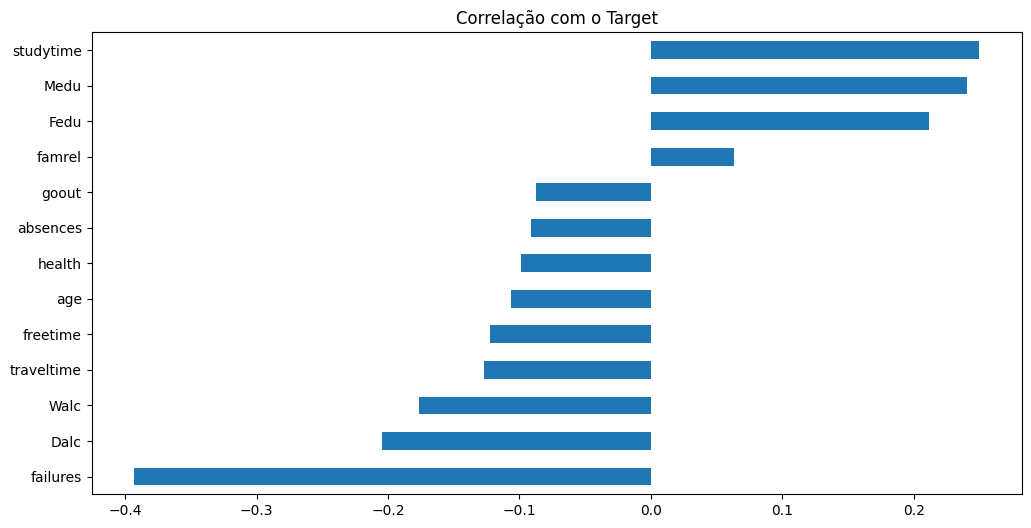

In [20]:
# Verificar distribuição do target
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True) # y.iloc[:, 0]
plt.title('Distribuição da Variável Target')
plt.show()

# Correlação entre features numéricas e target
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numeric_features].corrwith(target)
plt.figure(figsize=(12, 6))
correlations.sort_values().plot.barh()
plt.title('Correlação com o Target')
plt.show()

---

### 2. Modelagem com Algoritmos Supervisionados:
Utilizamos três modelos com diferentes arquiteturas/configurações, sendo eles:
- **Rede Neural:** Com arquitetura de 1 (32), 2 (64, 32) e 3 (128, 64, 32) camadas;
- **Árvore de Decisão:** Sendo as profundidades máximas 3, 5, 10, 20 e nenhuma;
- **Random Forest:** Sendo o número de árvores 50, 100 e 200 e profundidades máximas como 5, 10, 30 e nenhuma.

Além disso, estaremos extraindo de cada modelo e configuração as features mais **relevantes** e métricas de desempenho, como a MSE, RMSE e R².

In [21]:
# ------------------------- Random Forest Regressor -------------------------

n_estimators_list = [50, 100, 200]      # Número de árvores
max_depth_list = [5, 10, 30, None]      # Profundidade máxima

results_rf = []

# Verificar e garantir que y_train seja 1D
if len(y_train.shape) > 1 and y_train.shape[1] == 1:
    y_train = y_train.values.ravel()

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        RFR = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            criterion='squared_error', 
            min_samples_leaf=5, 
            n_jobs=1,
            random_state=42
        )
        RFR.fit(X_train, y_train)
        
        # Métricas
        y_pred = RFR.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Complexidade
        avg_depth = np.mean([tree.tree_.max_depth for tree in RFR.estimators_])
        n_params = sum(tree.tree_.n_node_samples.size for tree in RFR.estimators_)
        
        results_rf.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'avg_depth': avg_depth,
            'n_params': n_params,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

        # Guardando features relevantes
        feature_importance = RFR.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        print(f"\nFeatures mais relevantes para Random Forest - Profundidade máxima {max_depth} | Árvores {n_estimators}:")
        print(importance_df.head())

        """
        # Plotagem das predições
        
        plt.scatter(y_test, y_pred)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Valores Reais')
        plt.ylabel('Predições')
        plt.title(f'Predições vs Reais (R² = {r2:.2f}) - n_estimators={n_estimators}, max_depth={max_depth}')
        plt.show()

        """



Features mais relevantes para Random Forest - Profundidade máxima 5 | Árvores 50:
    Feature  Importance
1        G2    0.915632
5  absences    0.047785
0        G1    0.017445
3      Fedu    0.005090
2      Medu    0.004704

Features mais relevantes para Random Forest - Profundidade máxima 10 | Árvores 50:
    Feature  Importance
1        G2    0.905500
5  absences    0.049990
0        G1    0.019561
4      Walc    0.006758
3      Fedu    0.006276

Features mais relevantes para Random Forest - Profundidade máxima 30 | Árvores 50:
    Feature  Importance
1        G2    0.905478
5  absences    0.049986
0        G1    0.019561
4      Walc    0.006774
3      Fedu    0.006272

Features mais relevantes para Random Forest - Profundidade máxima None | Árvores 50:
    Feature  Importance
1        G2    0.905478
5  absences    0.049986
0        G1    0.019561
4      Walc    0.006774
3      Fedu    0.006272

Features mais relevantes para Random Forest - Profundidade máxima 5 | Árvores 100:
   

In [22]:
# ------------------------- Decision Tree Regressor -------------------------

max_depth_list = [3, 5, 10, 20, None]
results_dt = []

for max_depth in max_depth_list:
    DTR = DecisionTreeRegressor(
        max_depth=max_depth,
        criterion='squared_error',
        min_samples_leaf=5, 
        random_state=42
    )
    DTR.fit(X_train, y_train)
    
    # Métricas
    y_pred = DTR.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Complexidade
    n_nodes = DTR.tree_.node_count
    depth = DTR.tree_.max_depth
    
    results_dt.append({
        'max_depth_set': max_depth,
        'actual_depth': depth,
        'n_nodes': n_nodes,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
        
    })

    # Guardando features relevantes
    feature_importance = DTR.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(f"\nFeatures mais relevantes para Decision Tree - Profundidade máxima {max_depth}:")
    print(importance_df.head())


    """
    # Plotagem das predições

    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Predições')
    plt.title(f'Predições vs Reais (R² = {r2:.2f}) - Profundidade máxima={max_depth}')
    plt.show()

    """



Features mais relevantes para Decision Tree - Profundidade máxima 3:
  Feature  Importance
1      G2         1.0
0      G1         0.0
2    Medu         0.0
3    Fedu         0.0
4    Walc         0.0

Features mais relevantes para Decision Tree - Profundidade máxima 5:
    Feature  Importance
1        G2    0.948032
0        G1    0.020401
5  absences    0.018634
3      Fedu    0.005323
7  failures    0.004709

Features mais relevantes para Decision Tree - Profundidade máxima 10:
    Feature  Importance
1        G2    0.919115
0        G1    0.023935
5  absences    0.020566
4      Walc    0.017903
3      Fedu    0.006428

Features mais relevantes para Decision Tree - Profundidade máxima 20:
    Feature  Importance
1        G2    0.919174
0        G1    0.023793
5  absences    0.020551
4      Walc    0.018014
3      Fedu    0.006424

Features mais relevantes para Decision Tree - Profundidade máxima None:
    Feature  Importance
1        G2    0.919174
0        G1    0.023793
5  absenc

Epoch 1/200


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 151.2080 - mae: 11.7175 - val_loss: 156.4826 - val_mae: 12.1916
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 146.0357 - mae: 11.5954 - val_loss: 151.9684 - val_mae: 12.0295
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 145.5777 - mae: 11.6451 - val_loss: 147.6379 - val_mae: 11.8711
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 138.8004 - mae: 11.4441 - val_loss: 143.2658 - val_mae: 11.7059
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 138.2230 - mae: 11.3947 - val_loss: 138.8603 - val_mae: 11.5365
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 131.5485 - mae: 11.1454 - val_loss: 134.4364 - val_mae: 11.3640
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 128.1625 - mae: 11.0484 - val_loss: 130.0530 - val_mae: 11.1894
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 125.8745 - mae: 10.9427 - val_loss: 125.7158 - val_mae: 11.0148
Epoch 9/200
12/12 ━━━━━━━━━

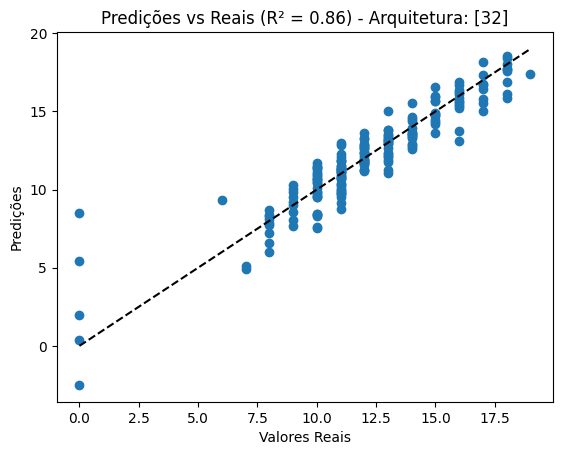

Epoch 1/200


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 169.7356 - mae: 12.5912 - val_loss: 157.2644 - val_mae: 12.2528
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 150.5698 - mae: 11.8380 - val_loss: 149.3911 - val_mae: 11.9359
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 134.5137 - mae: 11.1999 - val_loss: 141.7957 - val_mae: 11.6231
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 118.9988 - mae: 10.5460 - val_loss: 133.9431 - val_mae: 11.2914
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 105.5887 - mae: 9.9026 - val_loss: 125.4903 - val_mae: 10.9317
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 89.5555 - mae: 9.1067 - val_loss: 116.0507 - val_mae: 10.5160
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.4883 - mae: 8.3931 - val_loss: 105.4244 - val_mae: 10.0255
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 62.5860 - mae: 7.5369 - val_loss: 93.7580 - val_mae: 9.4524
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━

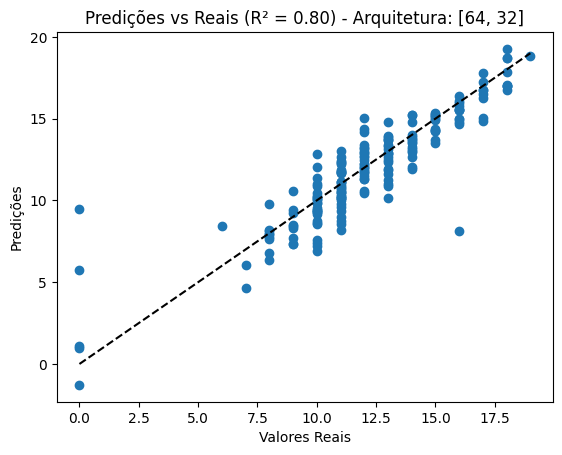

Epoch 1/200


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 171.9808 - mae: 12.6458 - val_loss: 144.6461 - val_mae: 11.7031
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 113.3209 - mae: 10.2353 - val_loss: 130.8879 - val_mae: 11.1474
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 72.4254 - mae: 8.0592 - val_loss: 112.7594 - val_mae: 10.3640
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 37.5800 - mae: 5.4680 - val_loss: 93.4006 - val_mae: 9.4343
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.9231 - mae: 3.5888 - val_loss: 81.5327 - val_mae: 8.8010
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.8189 - mae: 2.4558 - val_loss: 78.3296 - val_mae: 8.6071
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8813 - mae: 2.1841 - val_loss: 77.4823 - val_mae: 8.5487
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7201 - mae: 1.7812 - val_loss: 73.4142 - val_mae: 8.3194
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

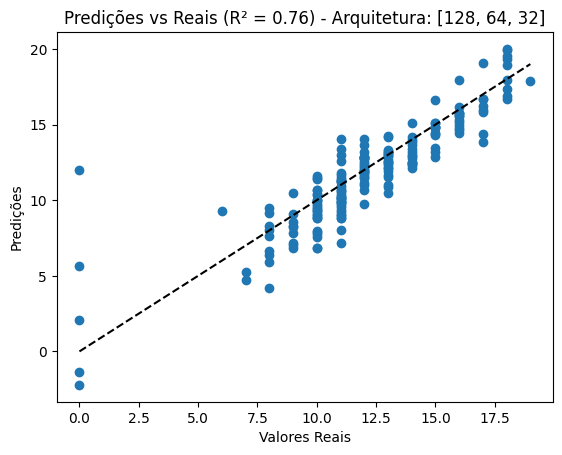

In [30]:
# ------------------------- Neural Network Regressor -------------------------
architectures = [
    [32],               # 1 camada
    [64, 32],           # 2 camadas
    [128, 64, 32]       # 3 camadas
]

results_nn = []

for architecture in architectures:
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Dense(architecture[0], 
                              activation='relu', 
                              input_shape=(X_train_scaled.shape[1],)
        ),
    )
    # Batch normalization para estabilizar a aprendizagem
    model.add(tf.keras.layers.BatchNormalization())
    # Dropout para evitar overfitting
    model.add(tf.keras.layers.Dropout(0.3))

    for units in architecture[1:]:
        model.add(tf.keras.layers.Dense(
                units, 
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        
    
    model.add(tf.keras.layers.Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer, 
        loss='mse', 
        metrics=['mae'])

    # Early stopping para evitar overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_loss',
        mode='min', 
        restore_best_weights=True)

    model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        shuffle=True,
        verbose=1
    )
    
    # Métricas
    y_pred = model.predict(X_test_scaled).flatten()
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Complexidade
    n_params = model.count_params()
    
    results_nn.append({
        'architecture': str(architecture),
        'n_params': n_params,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    # Guardando features relevantes da primeira camada
    weights = model.layers[0].get_weights()[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("Features mais relevantes para primeira camada da NN:")
    print(importance_df.head())

    # Plotagem das predições
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Predições')
    plt.title(f'Predições vs Reais (R² = {r2:.2f}) - Arquitetura: {architecture}')
    plt.show()


=== Treinando modelo com 10 neurônios ===

Top 5 features mais relevantes:
     Feature  Importance
7   failures    0.625127
4       Walc    0.587299
0         G1    0.538512
6  studytime    0.528434
3       Fedu    0.509733


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


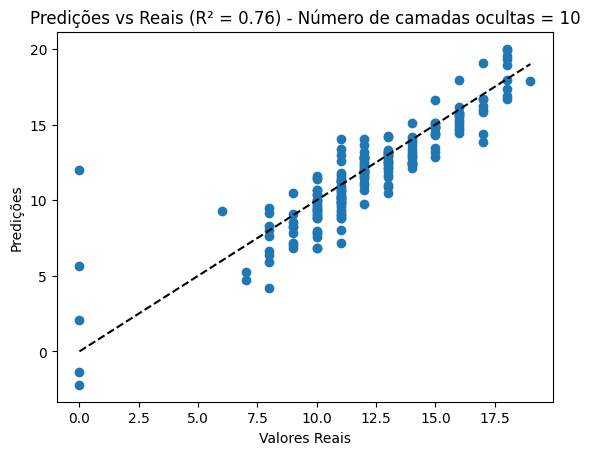


=== Treinando modelo com 20 neurônios ===

Top 5 features mais relevantes:
     Feature  Importance
7   failures    0.465131
4       Walc    0.423196
2       Medu    0.371563
6  studytime    0.358358
5   absences    0.343620


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


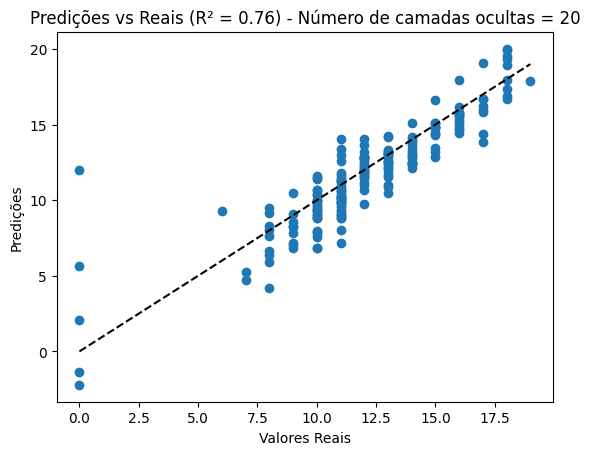


=== Treinando modelo com 50 neurônios ===

Top 5 features mais relevantes:
     Feature  Importance
0         G1    0.274557
4       Walc    0.271544
6  studytime    0.254593
3       Fedu    0.251802
7   failures    0.241344


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


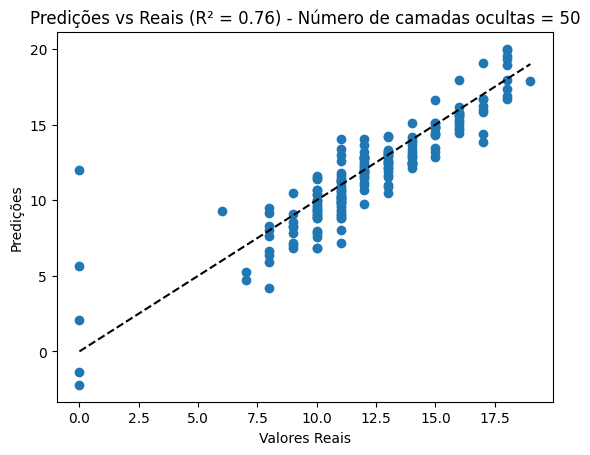


=== Treinando modelo com 100 neurônios ===

Top 5 features mais relevantes:
     Feature  Importance
5   absences    0.224975
7   failures    0.224663
1         G2    0.211515
4       Walc    0.211204
6  studytime    0.210751


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


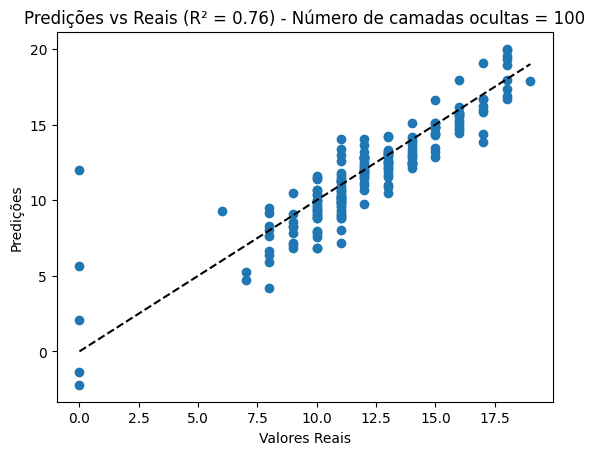


=== Treinando modelo com 200 neurônios ===

Top 5 features mais relevantes:
     Feature  Importance
7   failures    0.167633
4       Walc    0.167241
6  studytime    0.166666
0         G1    0.158030
5   absences    0.153802


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


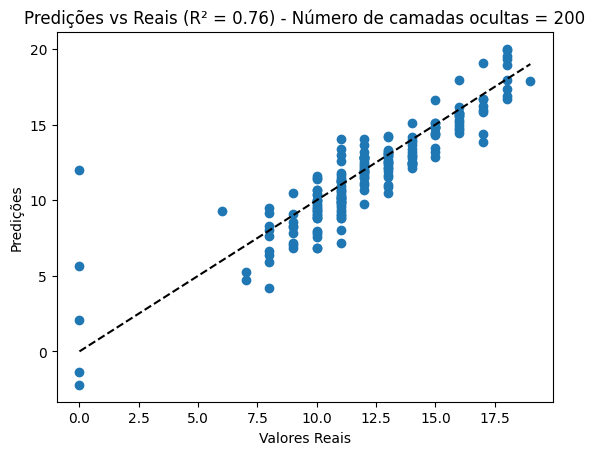

In [31]:
# ------------------------- MLP Regressor -------------------------
hidden_layers = [10, 20, 50, 100, 200]  # Número de neurônios nas camadas ocultas
results_mlp = []

def count_mlp_params(mlp):
    n_params = 0
    for weights in mlp.coefs_:
        n_params += weights.size
    for bias in mlp.intercepts_:
        n_params += bias.size
    return n_params

for layer in hidden_layers:
    print(f"\n=== Treinando modelo com {layer} neurônios ===")
    
    model = MLPRegressor(
        hidden_layer_sizes=(layer,), 
        max_iter=1000,
        solver='adam', 
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Métricas de classificação
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Complexidade
    n_params = count_mlp_params(model)
    
    results_mlp.append({
        'hidden_layers': layer,
        'n_params': n_params,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    # Features relevantes
    weights = model.coefs_[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("\nTop 5 features mais relevantes:")
    print(importance_df.head())
    
    # Plotagem das predições
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Predições')
    plt.title(f'Predições vs Reais (R² = {r2:.2f}) - Número de camadas ocultas = {layer}')
    plt.show()




---

### 3. Critérios de Avaliação:
**Erro de predição**: utilizar métricas como MSE, RMSE, acurácia, F1-score, conforme o tipo de problema.

**Complexidade do modelo**:
* **Redes neurais**: número de parâmetros treináveis.
* **Árvores de decisão**: profundidade ou número de nós.
* **Random Forest**: número de árvores e profundidade média.

In [32]:
# ------------------------- Visualização das métricas -------------------------
print("\nResultados da MLP:")
df_results_mlp = pd.DataFrame(results_mlp)
print(df_results_mlp.sort_values('R2', ascending=False))



Resultados da MLP:
   hidden_layers  n_params       MSE      RMSE        R2
0             10       101  2.696011  1.641953  0.756197
1             20       201  2.696011  1.641953  0.756197
2             50       501  2.696011  1.641953  0.756197
3            100      1001  2.696011  1.641953  0.756197
4            200      2001  2.696011  1.641953  0.756197


In [33]:
print("\nResultados da Rede Neural:")
df_results_nn = pd.DataFrame(results_nn)
print(df_results_nn.sort_values('R2', ascending=False))


Resultados da Rede Neural:
    architecture  n_params       MSE      RMSE        R2
0           [32]       449  1.574740  1.254887  0.857595
1       [64, 32]      2945  2.261652  1.503879  0.795476
2  [128, 64, 32]     12033  2.696011  1.641953  0.756197


In [34]:
print("\nResultados do Random Forest:")
df_results_rf = pd.DataFrame(results_rf)
print(df_results_rf.sort_values('R2', ascending=False))



Resultados do Random Forest:
    n_estimators  max_depth  avg_depth  n_params       MSE      RMSE        R2
8            200        5.0      5.000      9636  1.451448  1.204761  0.868744
0             50        5.0      5.000      2442  1.466871  1.211145  0.867349
4            100        5.0      5.000      4832  1.469290  1.212143  0.867131
9            200       10.0      9.040     17724  1.476197  1.214988  0.866506
11           200        NaN      9.145     17772  1.476460  1.215097  0.866482
10           200       30.0      9.145     17772  1.476460  1.215097  0.866482
1             50       10.0      8.840      4428  1.487815  1.219760  0.865455
2             50       30.0      8.960      4444  1.488013  1.219841  0.865437
3             50        NaN      8.960      4444  1.488013  1.219841  0.865437
5            100       10.0      8.930      8824  1.493206  1.221968  0.864968
7            100        NaN      9.040      8850  1.493514  1.222094  0.864940
6            100      

In [35]:
print("\nResultados do Decision Tree:")
df_results_dt = pd.DataFrame(results_dt)
print(df_results_dt)


Resultados do Decision Tree:
   max_depth_set  actual_depth  n_nodes       MSE      RMSE        R2
0            3.0             3       15  1.770764  1.330700  0.839868
1            5.0             5       53  1.700706  1.304111  0.846203
2           10.0            10      141  1.949207  1.396140  0.823731
3           20.0            11      145  1.946269  1.395087  0.823997
4            NaN            11      145  1.946269  1.395087  0.823997


---

### 4. Otimização Multiobjetivo:
A abordagem utilizada para encontrar modelos que equilibrem desempenho e complexidade foi a análise e visualização da **Fronteira de Pareto**.

In [36]:
# ------------------------- Análise Multiobjetivo -------------------------

# Adicionar coluna de modelo para cada DataFrame
df_results_nn['model'] = 'Neural Network'
df_results_mlp['model'] = 'MLP Regressor'
df_results_rf['model'] = 'Random Forest'
df_results_dt['model'] = 'Decision Tree'

# Selecionando apenas colunas relevantes
df_results_dt = df_results_dt[['n_nodes', 'R2']]
df_results_dt['n_params'] = df_results_dt['n_nodes']
df_results_rf = df_results_rf[['n_params', 'R2']]
df_results_nn = df_results_nn[['n_params', 'R2']]
df_results_mlp = df_results_mlp[['n_params', 'R2']]

# Unificando resultados em um dataframe
df_all = pd.concat([
    df_results_nn.assign(model='Neural Network'),
    df_results_mlp.assign(model='MLP Regressor'),
    df_results_rf.assign(model='Random Forest'),
    df_results_dt.assign(model='Decision Tree')
], ignore_index=True)

In [37]:
def is_pareto_efficient(df):
    data = df[['n_params', 'R2']].copy()
    # Muda R² para -R² para poder usar algoritmo de minimização
    data['R2'] = -data['R2']
    # Convertendo para numpy array
    costs = data.to_numpy()
    
    # Inicializa um array booleano para identificar soluções eficientes
    is_efficient = np.ones(costs.shape[0], dtype=bool)

    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Verifica se há outras soluções que são melhores ou iguais em todos os objetivos
            # descarta soluções que são dominadas
            is_efficient[is_efficient] = (
                np.any(costs[is_efficient] < c, axis=1) | 
                np.all(costs[is_efficient] == c, axis=1)
            )
            is_efficient[i] = True # garante que a solução atual é considerada eficiente
    return is_efficient


df_all['pareto'] = is_pareto_efficient(df_all)
pareto_df = df_all[df_all['pareto']] # DataFrame com soluções eficientes de Pareto


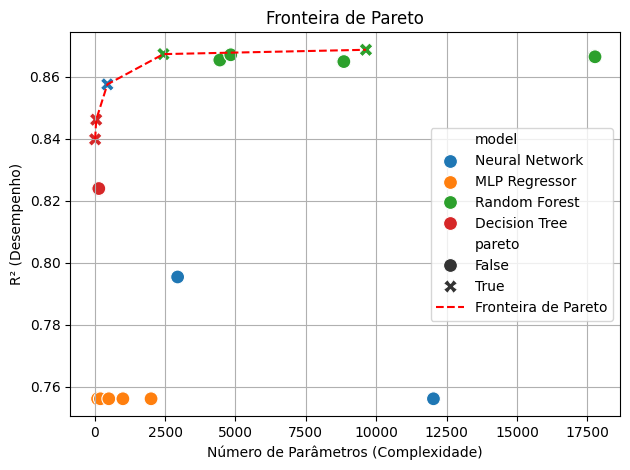

In [ ]:
# ------------------------- Visualização da Fronteira de Pareto -------------------------
sns.scatterplot(
    data=df_all, 
    x='n_params', 
    y='R2', 
    hue='model', 
    style='pareto', 
    s=100)

pareto_sorted = pareto_df.sort_values('n_params')

plt.plot(
    pareto_sorted['n_params'], 
    pareto_sorted['R2'], 
    linestyle='--', 
    color='red', 
    label='Fronteira de Pareto')


plt.xlabel('Número de Parâmetros (Complexidade)')
plt.ylabel('R² (Desempenho)')
plt.title('Fronteira de Pareto - Student Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()